In [1]:
import pickle
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N_players = 5
players = [f'player{i}' for i in range(1, N_players+1)]
n_components = 3 # num of hidden states
n_features = 3 # num of observed states
O_symbols = [0, 1, 2] # under-, avg-, over- performance
H_symbols = [0, 1, 2] # corresponding mental states
T = 1000
N_samples = 100 # Samples per simulated run

In [3]:
np.random.seed(42)
plot_folder = './plots/'

In [4]:
class TeamModel:
    def __init__(self, name, initial_dist, M, N, R, emission_prob):
        self.name = name
        
        self.initial_dist = initial_dist
        
        # Transition matrices
        self.M = M # dictionary. key = player, value = a row-stochastic matrix, observation-to-state transitions
        self.N = N # dictionary. key = player, value = a row-stochastic matrix, state-to-state transitions
        
        # Graph weights - Tie strengh
        self.R = R # row-stochastic matrix
        
        # Emission matrices
        self.emission_prob = emission_prob # for each player, a row-stochastic matrix
        
        # Store latest hidden and observed states
        self.H = None
        self.O = None
    
        self.t = 0
   
    def check_input_parameters(self):
        pass
    
    def next(self):
        if self.t == 0:
            self.H = {p: np.random.choice(H_symbols, p=self.initial_dist) for p in players}
            self.O = {p: np.random.choice(O_symbols, p=self.emission_prob[p][self.H[p]]) for p in players}
            self.t = 1
            
            return self.H, self.O
            
        H_new = {}
        O_new = {}
        for p in players:
            R_ = self.R[p]
            emission_ = self.emission_prob[p]
            
            # produce next hidden state
            dist = []
            for h in H_symbols: # calculate the probability of each next state h
                v = []
                v.append(self.N[p][self.H[p]][h]) # P(H_t^player = h | H__{t-1}^player = H[player])
                for teammate in players:
                    v.append(self.M[(p, teammate)][self.O[teammate]][h]) # P(H_t^player = h | O_{t-1}^teammate = O[teammate])

                v = np.array(v)
                
                dist.append(np.dot(R_, v))
            
            h_new = np.random.choice(H_symbols, p=dist)
            
            # produce next observation
            o_new = np.random.choice(O_symbols, p=emission_[h_new])
            
            # Add new values to
            H_new[p] = h_new
            O_new[p] = o_new
            
        # Update hidden and observed states
        self.H = H_new
        self.O = O_new
        
        # Update time
        self.t += 1
        
        return H_new, O_new
    
    def get_data(self, T = 1000):
        # T = number of observations (i.e. number of iterations)
        self.restart()
        data = []
        for _ in range(T):
            H, O = self.next()
            data.append((H, O))
        return data
    
    def restart(self):
        self.H = None
        self.O = None
        self.t = 0

In [5]:
def countTeamCollapses(Hs):
    state_hist = list(zip(*[Hs[p] for p in players]))
    cnt = state_hist.count(tuple([0 for p in players]))
#     cnt = sum([1 for states in state_hist if sum(states) <= 2])
    return cnt

def teamHasCollapsed(states):
    return sum(states) == 0 # all players have collapsed

def teamState(states):
    return sum(states)

In [6]:
def produce(model, T): # produce T timeseries samples (each of N_samples points) from the model 
    data = []
    data = model.get_data(T)

    # Store data
    observations = {player: [] for player in players}
    true_hidden = {player: [] for player in players}
    for (h, o) in data:
        for player in players:
            true_hidden[player].append(h[player])
            observations[player].append(o[player])

    for player in players:
        observations[player] = np.array(observations[player])
        true_hidden[player] = np.array(true_hidden[player])
        
    return observations, true_hidden

In [7]:
# === M ===
avg_transO = np.array([[0.5, 0.3, 0.2],
                       [0.25, 0.5, 0.25],
                       [0.2, 0.3, 0.5]])

star_transO = np.array([[0.8, 0.2, 0],
                        [0.1, 0.8, 0.1],
                       [0, 0.2, 0.8]])

anti_dependent_transO = np.array([[0, 0.2, 0.8],
                                 [0.1, 0.8, 0.1],
                                 [0.8, 0.2, 0]])
# === N ===
avg_transH = np.array([[0.8, 0.2, 0.0],
                       [0.1, 0.8, 0.1],
                       [0.0, 0.2, 0.8]])

# === emission_prob ===
avg_emission = np.array([[0.8, 0.2, 0.0],
                       [0.1, 0.8, 0.1],
                       [0.0, 0.2, 0.8]])

star_emission = np.array([[0.7, 0.3, 0.0],
                        [0.1, 0.8, 0.1],
                        [0.0, 0.1, 0.9]])

# ===  R ===
R_singleH = np.array([1] + [0] * len(players))
def R_singleHO(player):
    i = int(player[-1])
    arr = [0] * (len(players)+1)
    arr[0] = 0.8
    arr[i] = 0.2
    return np.array(arr)

def R_star(player, star):
    if player == star:
        return R_singleH
    arr = [0] * (len(players)+1)
    i = int(star[-1])
    arr[i] = 1
    return np.array(arr)

def R_star_plus_hidden(player, star):
    if player == star:
        return R_singleH
    arr = [0] * (len(players)+1)
    i = int(star[-1])
    arr[i] = 0.5
    arr[0] = 0.5
    return np.array(arr)

def R_two_stars(player, star1, star2):
    if player == star1 or player == star2:
        return R_singleH
    arr = [0] * (len(players)+1)
    i = int(star1[-1])
    j = int(star2[-1])
    arr[i] = 0.5
    arr[j] = 0.5
    return np.array(arr)

def R_two_stars_plus_hidden(player, star1, star2):
    if player == star1 or player == star2:
        return R_singleH
    arr = [0] * (len(players)+1)
    i = int(star1[-1])
    j = int(star2[-1])
    arr[i] = 0.25
    arr[j] = 0.25
    arr[0] = 0.5
    return np.array(arr)
    
R_uniform = np.array([1/(1 + len(players))] * (len(players) + 1))

In [8]:
observed_states = dict()
hidden_states = dict()

team_states = dict()
team_observations = dict()

res = dict()
hidden_collapse_time = dict()
observed_collapse_time = dict()

zone4_6_hidden = dict()
zone4_6_observed = dict()
zone3_7_hidden = dict()
zone3_7_observed = dict()
zone5_10_hidden = dict()
zone5_10_observed = dict()
zone0_5_hidden = dict()
zone0_5_observed = dict()
zone0_2_hidden = dict()
zone0_2_observed = dict()
zone8_10_hidden = dict()
zone8_10_observed = dict()

def generate_data(model):
    name = model.name
    observed_states[name] = dict()
    hidden_states[name] = dict()
    team_states[name] = dict()
    team_observations[name] = dict()
    
    for t in range(T):
        observed_states[name][t], hidden_states[name][t] = produce(model, N_samples)
        
        # Team cumulative hidden states and observations
        state_hist = list(zip(*[hidden_states[name][t][p] for p in players]))
        observed_hist = list(zip(*[observed_states[name][t][p] for p in players]))
        team_states[name][t] = np.array([sum(states) for states in state_hist])
        team_observations[name][t] = np.array([sum(states) for states in observed_hist])
        
def calculate_stats(model):
    name = model.name
    
    Os = observed_states[name]
    Hs = hidden_states[name]
    
    res[name] = 0
    for t in range(T):
        res[name] += countTeamCollapses(Hs[t])
        
    hidden_collapse_time[name] = average_length_contiguous(team_states[name], lambda x : x == 0)
    observed_collapse_time[name] = average_length_contiguous(team_observations[name], lambda x: x == 0)
    
    zone4_6_hidden[name] = average_length_contiguous(team_states[name], lambda x : x >= 4 and x <= 6)
    zone4_6_observed[name] = average_length_contiguous(team_observations[name], lambda x : x > 4 and x <= 6)
    
    zone3_7_hidden[name] = average_length_contiguous(team_states[name], lambda x : x >= 3 and x <= 7)
    zone3_7_observed[name] = average_length_contiguous(team_observations[name], lambda x : x >= 3 and x <= 7)
    
    zone5_10_hidden[name] = average_length_contiguous(team_states[name], lambda x : x > 5 and x <= 10)
    zone5_10_observed[name] = average_length_contiguous(team_observations[name], lambda x : x > 5 and x <= 10)
    
    zone0_5_hidden[name] = average_length_contiguous(team_states[name], lambda x : x >= 0 and x < 5)
    zone0_5_observed[name] = average_length_contiguous(team_observations[name], lambda x : x >= 0 and x <= 5)
    
    zone0_2_hidden[name] = average_length_contiguous(team_states[name], lambda x : x >= 0 and x <= 2)
    zone0_2_observed[name] = average_length_contiguous(team_observations[name], lambda x : x >= 0 and x <= 2)
    
    zone8_10_hidden[name] = average_length_contiguous(team_states[name], lambda x : x >= 8 and x <= 10)
    zone8_10_observed[name] = average_length_contiguous(team_observations[name], lambda x : x >= 8 and x <= 10)
    
    time_series_arrays = list(team_states[name].values())
    
    # Hidden states stats
    # Calculate average, min, and max time series
    avg_series = np.mean(time_series_arrays, axis=0)
    min_series = np.min(time_series_arrays, axis=0)
    max_series = np.max(time_series_arrays, axis=0)
    
    # Calculate percentiles for shading
    perc_25 = np.percentile(time_series_arrays, 25, axis=0)
    perc_75 = np.percentile(time_series_arrays, 75, axis=0)
    
    # Observed states stats
    time_series_arrays = list(team_observations[name].values())
    avg_observed_series = np.mean(time_series_arrays, axis=0)

    
    return avg_series, min_series, max_series, perc_25, perc_75, avg_observed_series

def plot_team_state(model):
    name = model.name
    
    avg_series, min_series, max_series, perc_25, perc_75, avg_observed_series = calculate_stats(model)
    
    # Center at 0 and divide with 5 to obtain average
    avg_series = avg_series / 5 - 1
    min_series = min_series / 5 - 1
    max_series = max_series / 5 - 1
    perc_25 = perc_25 / 5 - 1
    perc_75 = perc_75 / 5 - 1
    avg_observed_series = avg_observed_series / 5 - 1
    
    # Plot average line
    sns.lineplot(data=avg_series, color='red', label='Average Hidden')
    
    # Fill area between average and min
    plt.fill_between(range(N_samples), avg_series, min_series, color='green', alpha=0.3)

    # Fill area between average and max
    plt.fill_between(range(N_samples), avg_series, max_series, color='green', alpha=0.3)
    
    # Fill area between average and 33rd percentile with gradient color
    plt.fill_between(range(N_samples), avg_series, perc_25, color='green', alpha=0.5)

    # Fill area between average and 66th percentile with gradient color
    plt.fill_between(range(N_samples), avg_series, perc_75, color='green', alpha=0.5)
   
    # Plot average observed line
    sns.lineplot(data=avg_observed_series, color='orange', label='Average Observed')

#     plt.title(f'Average, min, and max team state for {name}')
    plt.xlabel('Time')
    plt.ylabel('Team state')
    plt.legend()
    plt.savefig(f'{plot_folder}/team_state_{name}.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

In [9]:
def average_length_contiguous(timeseries_dict, f): # f : Int -> Bool
    lengths = []

    for key, series in timeseries_dict.items():
        zero_lengths = []
        current_length = 0
        for value in series:
            if f(value):
                current_length += 1
            else:
                if current_length > 0:
                    zero_lengths.append(current_length)
                    current_length = 0
        if current_length > 0:
            zero_lengths.append(current_length)
            
        lengths += zero_lengths
    
    lengths = np.array(lengths)

    return lengths

In [10]:
models = []

## Single Hidden

In [11]:
M = {(p1, p2): avg_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
R = {player: R_singleH for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('H', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([1, 0, 0, 0, 0, 0]),
 'player3': array([1, 0, 0, 0, 0, 0]),
 'player4': array([1, 0, 0, 0, 0, 0]),
 'player5': array([1, 0, 0, 0, 0, 0])}

## Single Hidden + Observed

In [12]:
M = {(p1, p2): avg_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
R = {player: R_singleHO(player) for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('HO', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([0.8, 0.2, 0. , 0. , 0. , 0. ]),
 'player2': array([0.8, 0. , 0.2, 0. , 0. , 0. ]),
 'player3': array([0.8, 0. , 0. , 0.2, 0. , 0. ]),
 'player4': array([0.8, 0. , 0. , 0. , 0.2, 0. ]),
 'player5': array([0.8, 0. , 0. , 0. , 0. , 0.2])}

## Single Star

In [13]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
R = {player: R_star(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('1P', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0, 1, 0, 0, 0, 0]),
 'player3': array([0, 1, 0, 0, 0, 0]),
 'player4': array([0, 1, 0, 0, 0, 0]),
 'player5': array([0, 1, 0, 0, 0, 0])}

## Single star + Hidden

In [14]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star_plus_hidden(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('1P + H', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player3': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player4': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player5': array([0.5, 0.5, 0. , 0. , 0. , 0. ])}

## Single star + Anti-dependent non-star (1-Star + H + antiD)

In [15]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
# Add anti-dependence on non-star player 'player2'
for p in players:
    M[('player1', p)] = anti_dependent_transO
    M[('player2', p)] = anti_dependent_transO
    
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star_plus_hidden(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('1P + H + antiD', initial_dist, M, N, R, emission_prob)
models.append(model)

## Bad teammate - single star (BT1S)

In [16]:
M_bad_loser = np.array([[0.9, 0.1, 0],
                        [0.1, 0.8, 0.1],
                        [0.2, 0.3, 0.5]])
M = {(p1, p2): M_bad_loser for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('BT1P', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0, 1, 0, 0, 0, 0]),
 'player3': array([0, 1, 0, 0, 0, 0]),
 'player4': array([0, 1, 0, 0, 0, 0]),
 'player5': array([0, 1, 0, 0, 0, 0])}

## Bad teammate - single star + Hidden (BT1S + Hidden)

In [17]:
M_bad_loser = np.array([[0.9, 0.1, 0],
                        [0.1, 0.8, 0.1],
                        [0.2, 0.3, 0.5]])
M = {(p1, p2): M_bad_loser for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star_plus_hidden(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('BT1P + H', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player3': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player4': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player5': array([0.5, 0.5, 0. , 0. , 0. , 0. ])}

## Great teammate - Single star (GTSS)

In [18]:
M_great_teammate = np.array([[0.5, 0.3, 0.2],
                        [0.1, 0.8, 0.1],
                        [0.0, 0.1, 0.9]])
M = {(p1, p2): M_great_teammate for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('GT1P', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0, 1, 0, 0, 0, 0]),
 'player3': array([0, 1, 0, 0, 0, 0]),
 'player4': array([0, 1, 0, 0, 0, 0]),
 'player5': array([0, 1, 0, 0, 0, 0])}

## Great teammate - single star + Hidden (GT1S + H)

In [19]:
M_great_teammate = np.array([[0.5, 0.3, 0.2],
                        [0.1, 0.8, 0.1],
                        [0.0, 0.1, 0.9]])
M = {(p1, p2): M_great_teammate for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
R = {player: R_star_plus_hidden(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('GT1P + H', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player3': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player4': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player5': array([0.5, 0.5, 0. , 0. , 0. , 0. ])}

## 2 stars

In [20]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission

R = {player: R_two_stars(player, 'player1', 'player2') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('2P', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([1, 0, 0, 0, 0, 0]),
 'player3': array([0. , 0.5, 0.5, 0. , 0. , 0. ]),
 'player4': array([0. , 0.5, 0.5, 0. , 0. , 0. ]),
 'player5': array([0. , 0.5, 0.5, 0. , 0. , 0. ])}

## 2-stars with dependence (2-Stars + D)

In [21]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission

R = {player: R_two_stars(player, 'player1', 'player2') for player in players}
R['player1'] = R_star_plus_hidden('player1', 'player2') # Add star dependence
R['player2'] = R_star_plus_hidden('player2', 'player1')
initial_dist = np.array([0, 1, 0])

model = TeamModel('2P + D', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([0.5, 0. , 0.5, 0. , 0. , 0. ]),
 'player2': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player3': array([0. , 0.5, 0.5, 0. , 0. , 0. ]),
 'player4': array([0. , 0.5, 0.5, 0. , 0. , 0. ]),
 'player5': array([0. , 0.5, 0.5, 0. , 0. , 0. ])}

## 2-stars with anti-dependence (2-Stars + antiD)

In [22]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

# Add anti-dependence
for p in players:
    M[('player1', p)] = anti_dependent_transO
emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission

R = {player: R_two_stars(player, 'player1', 'player2') for player in players}
R['player1'] = R_star_plus_hidden('player1', 'player2') # Add star dependence
R['player2'] = R_star_plus_hidden('player2', 'player1')
initial_dist = np.array([0, 1, 0])

model = TeamModel('2P + antiD', initial_dist, M, N, R, emission_prob)
models.append(model)

## 2-Stars + Hidden (2-Stars + H)

In [23]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission

R = {player: R_two_stars_plus_hidden(player, 'player1', 'player2') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('2P + H', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([1, 0, 0, 0, 0, 0]),
 'player3': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ]),
 'player4': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ]),
 'player5': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ])}

## 2-Stars + Hidden with dependence (2-Stars + H + D)

In [24]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission

R = {player: R_two_stars_plus_hidden(player, 'player1', 'player2') for player in players}
R['player1'] = R_star_plus_hidden('player1', 'player2') # Add star dependence
R['player2'] = R_star_plus_hidden('player2', 'player1')
initial_dist = np.array([0, 1, 0])

model = TeamModel('2P + H + D', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([0.5, 0. , 0.5, 0. , 0. , 0. ]),
 'player2': array([0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'player3': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ]),
 'player4': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ]),
 'player5': array([0.5 , 0.25, 0.25, 0.  , 0.  , 0.  ])}

## 3-stars

In [25]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission
emission_prob['player3'] = star_emission

R = dict()
R['player1'] = R['player2'] = R['player3'] = R_singleH
R['player4'] = R['player5'] = np.array([0, 0.33, 0.33, 0.34, 0, 0])
initial_dist = np.array([0, 1, 0])

model = TeamModel('3P', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([1, 0, 0, 0, 0, 0]),
 'player2': array([1, 0, 0, 0, 0, 0]),
 'player3': array([1, 0, 0, 0, 0, 0]),
 'player4': array([0.  , 0.33, 0.33, 0.34, 0.  , 0.  ]),
 'player5': array([0.  , 0.33, 0.33, 0.34, 0.  , 0.  ])}

## 3-Stars with dependence (3-Stars + D)

In [26]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission
emission_prob['player3'] = star_emission

R = dict()
R['player1'] = np.array([0.5, 0, 0.25, 0.25, 0, 0])
R['player2'] = np.array([0.5, 0.25, 0, 0.25, 0, 0])
R['player3'] = np.array([0.5, 0.25, 0.25, 0, 0, 0])

R['player4'] = R['player5'] = np.array([0.5, 0.2, 0.2, 0.1, 0, 0])
initial_dist = np.array([0, 1, 0])

model = TeamModel('3P + D', initial_dist, M, N, R, emission_prob)
models.append(model)

## 3-stars + Hidden (3-Stars + H)

In [27]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission
emission_prob['player3'] = star_emission

R = dict()
R['player1'] = R['player2'] = R['player3'] = R_singleH
R['player4'] = R['player5'] = np.array([0.5, 0.2, 0.2, 0.1, 0, 0])
initial_dist = np.array([0, 1, 0])

model = TeamModel('3P + H', initial_dist, M, N, R, emission_prob)
models.append(model)

## 3-stars + Hidden with dependence (3-Stars + H + D)

In [28]:
M = {(p1, p2): star_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}

emission_prob = {player: avg_emission for player in players}
emission_prob['player1'] = star_emission
emission_prob['player2'] = star_emission
emission_prob['player3'] = star_emission

R = dict()
R['player1'] = np.array([0.5, 0, 0.25, 0.25, 0, 0])
R['player2'] = np.array([0.5, 0.25, 0, 0.25, 0, 0])
R['player3'] = np.array([0.5, 0.25, 0.25, 0, 0, 0])
R['player4'] = R['player5'] = np.array([0.5, 0.2, 0.2, 0.1, 0, 0])
initial_dist = np.array([0, 1, 0])

model = TeamModel('3P + H + D', initial_dist, M, N, R, emission_prob)
models.append(model)

## Balanced

In [29]:
M = {(p1, p2): avg_transO for p1 in players for p2 in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
R = {player: R_uniform for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel('Balanced', initial_dist, M, N, R, emission_prob)
models.append(model)
R

{'player1': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]),
 'player2': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]),
 'player3': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]),
 'player4': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]),
 'player5': array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667])}

# Experiments

## Team state timeseries for each team profile

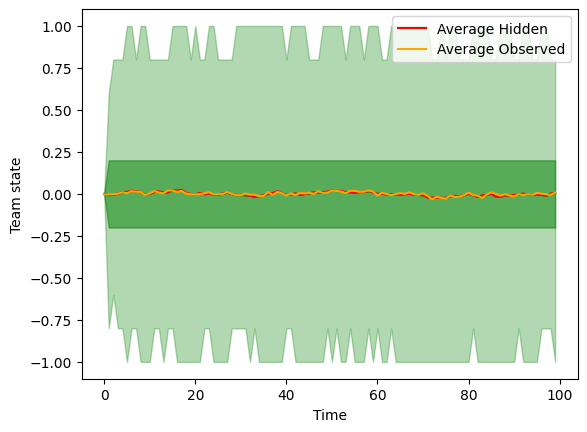

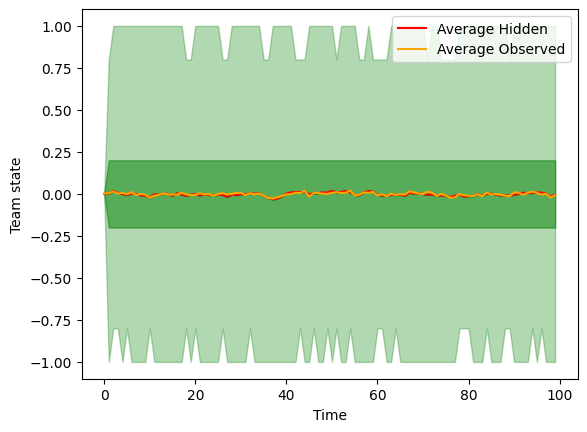

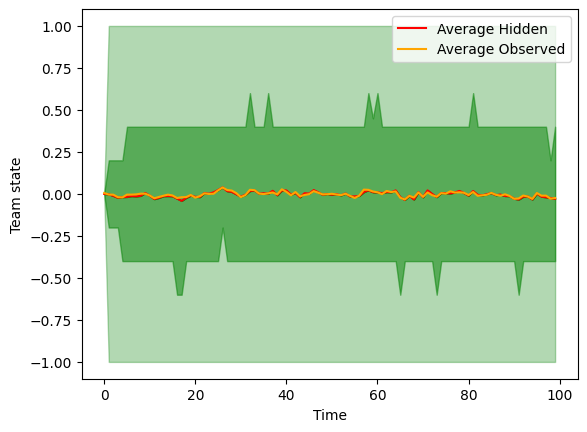

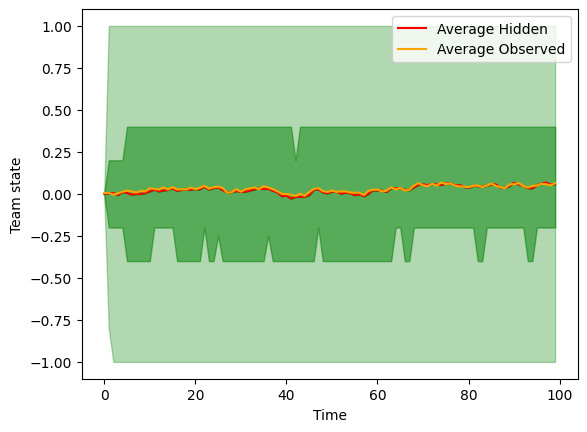

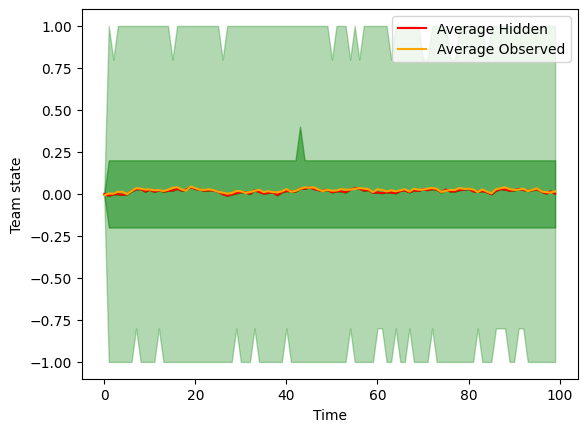

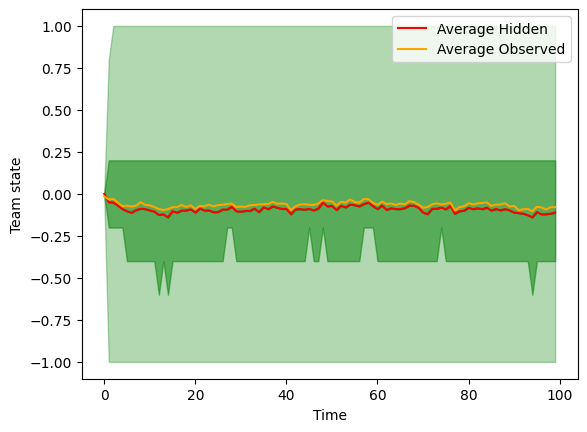

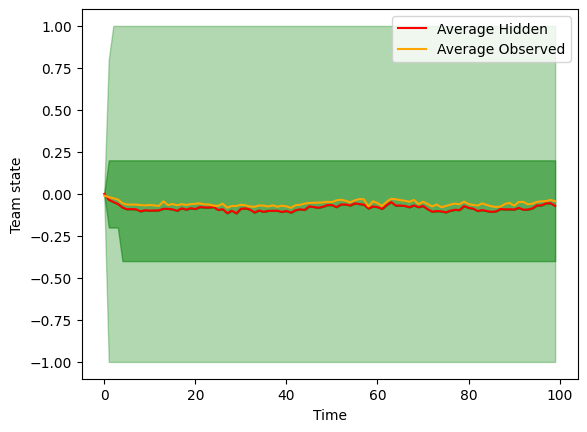

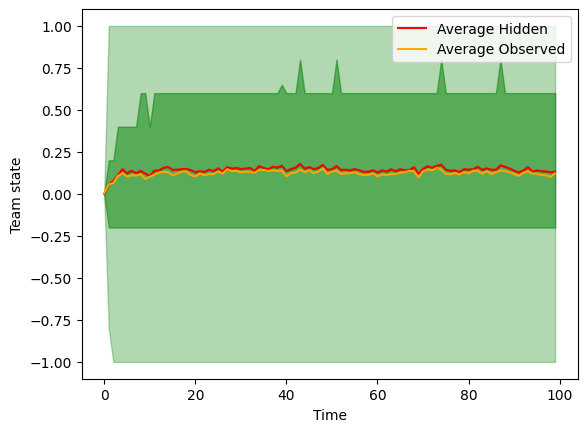

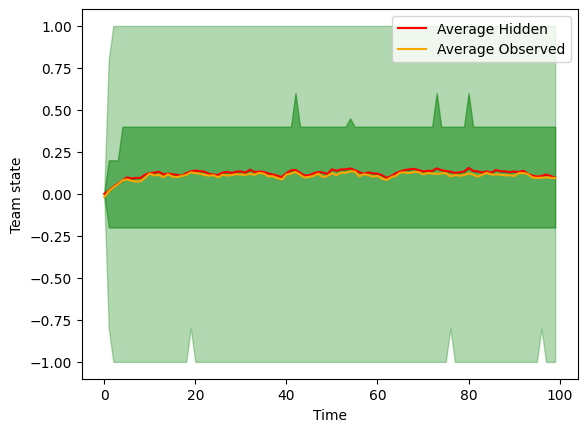

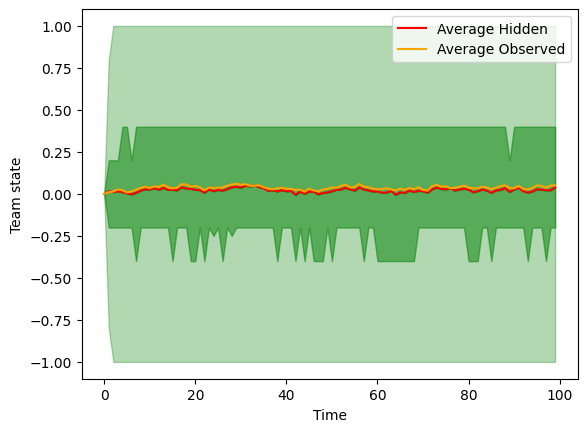

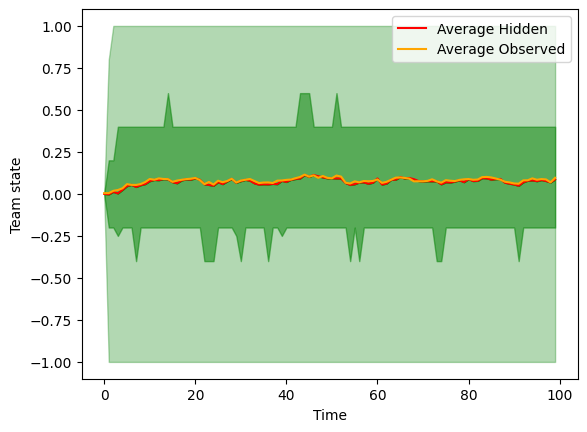

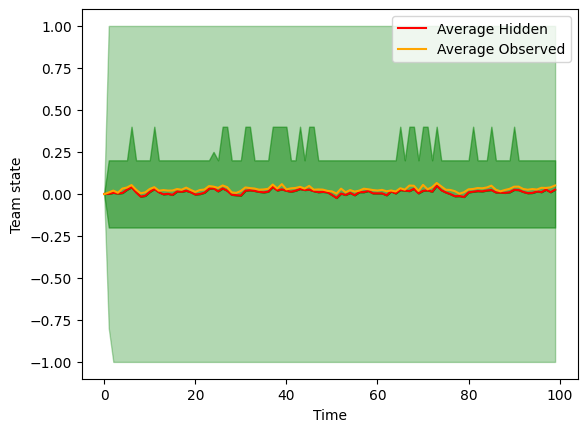

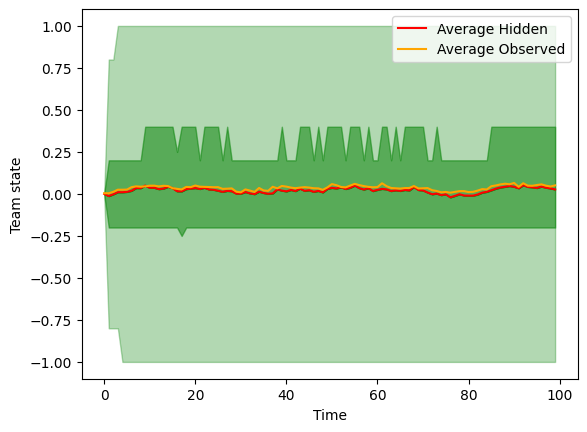

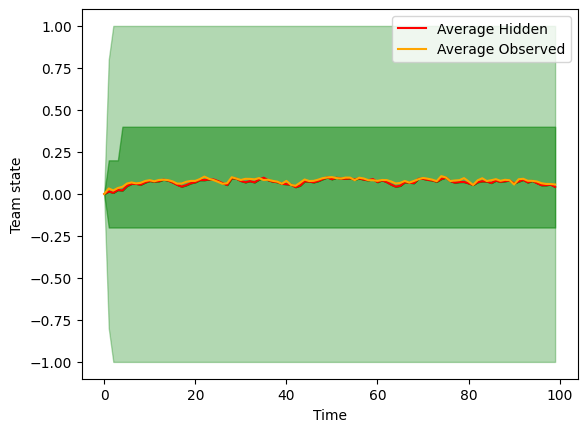

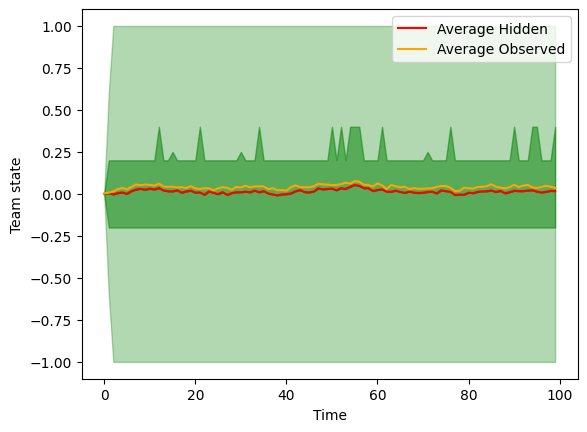

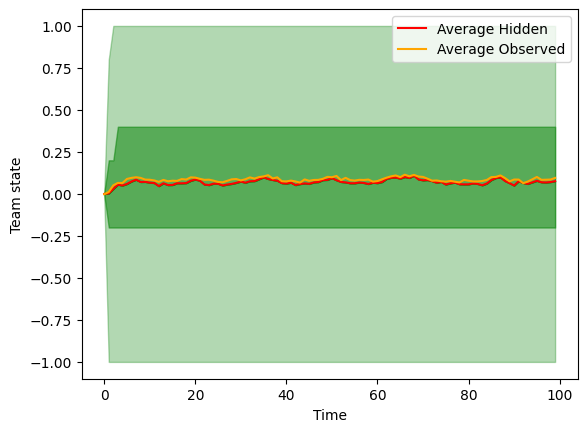

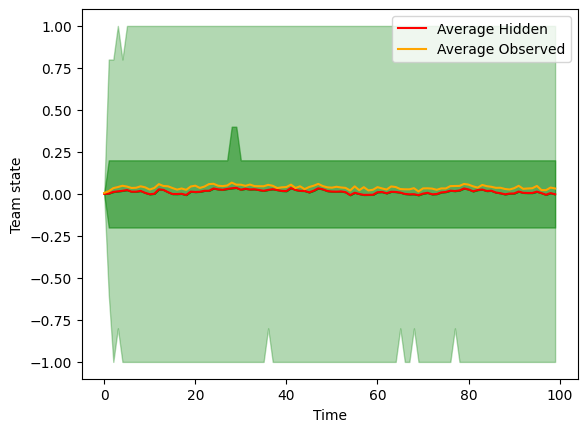

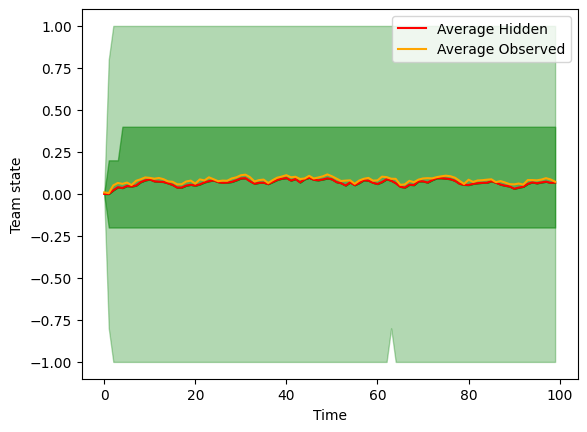

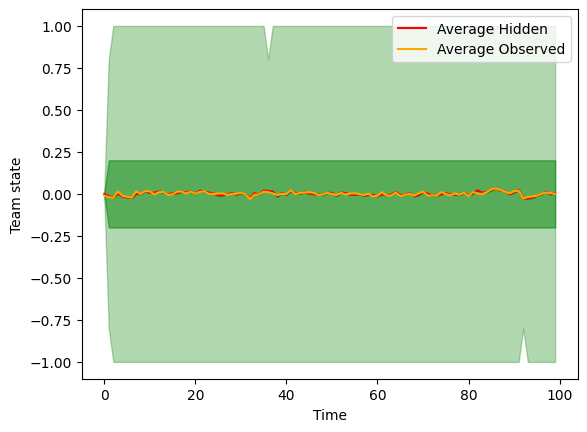

In [30]:
for model in models:
    generate_data(model)
    plot_team_state(model)

## Team collapse probability vs Team profile (selected profiles)

In [31]:
profiles = ['H', 'HO', '1P', '1P + H', '2P', '2P + D', '3P']

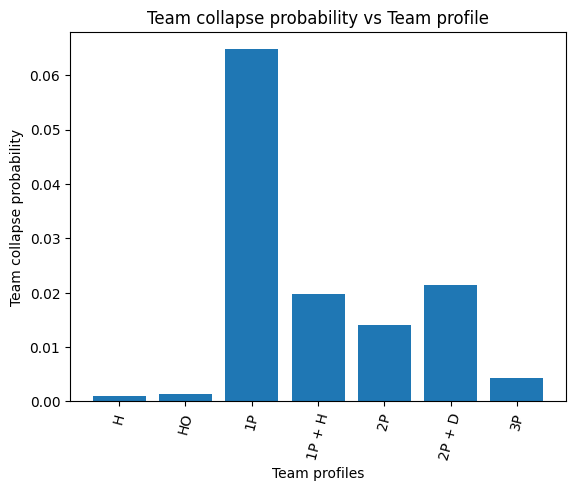

In [32]:
collapse_probs = [np.array(res[prof]) / (T * N_samples) for prof in res if prof in profiles]
keys = [prof for prof in res if prof in profiles]
plt.bar(keys, collapse_probs)

plt.xlabel('Team profiles')
plt.ylabel('Team collapse probability')
plt.title('Team collapse probability vs Team profile')

plt.xticks(rotation=75)
plt.savefig(f'{plot_folder}/collapse_prob_selected.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Team collapse probability vs Team profile

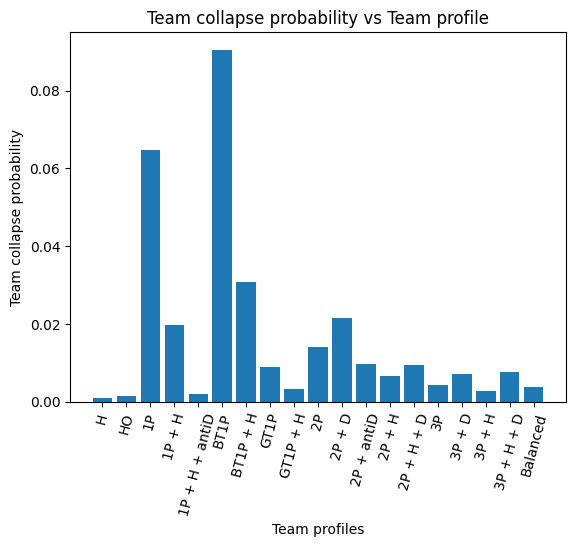

In [33]:
collapse_probs = np.array(list(res.values())) / (T * N_samples)
profiles = res.keys()

plt.bar(profiles, collapse_probs)

plt.xlabel('Team profiles')
plt.ylabel('Team collapse probability')
plt.title('Team collapse probability vs Team profile')

plt.xticks(rotation=75)
plt.savefig(f'{plot_folder}/collapse_prob.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Average time in team collapse

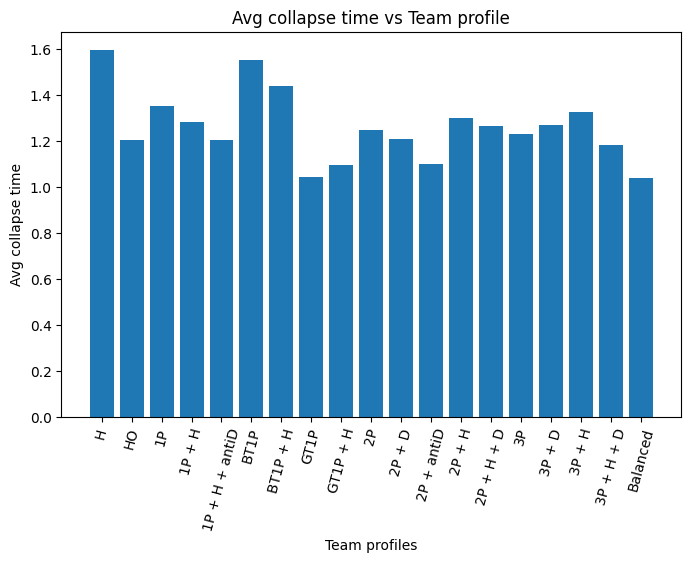

In [34]:
profiles = hidden_collapse_time.keys()

plt.gcf().set_size_inches(8, 5)
plt.bar(profiles, [np.mean(arr) for arr in hidden_collapse_time.values()])

plt.xlabel('Team profiles')
plt.ylabel('Avg collapse time')
plt.title('Avg collapse time vs Team profile')

plt.xticks(rotation=75)
plt.savefig(f'{plot_folder}/avg_time_in_collapse.pdf', format='pdf', bbox_inches='tight')
plt.show()

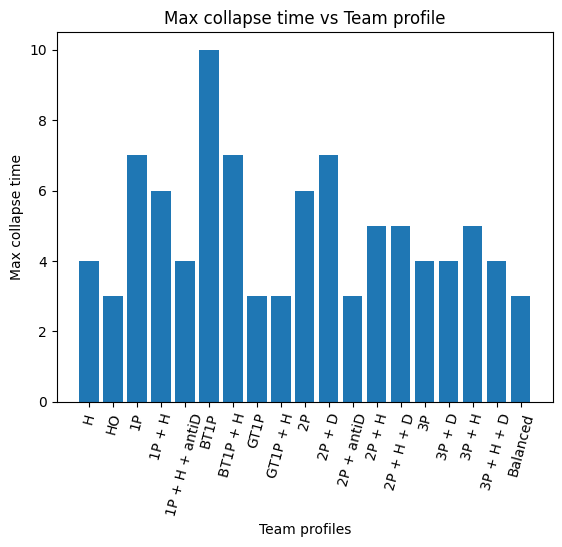

In [35]:
profiles = hidden_collapse_time.keys()

plt.bar(profiles, [np.max(arr) for arr in hidden_collapse_time.values()])

plt.xlabel('Team profiles')
plt.ylabel('Max collapse time')
plt.title('Max collapse time vs Team profile')

plt.xticks(rotation=75)
plt.savefig(f'{plot_folder}/max_time_in_collapse.pdf', format='pdf', bbox_inches='tight')

plt.show()

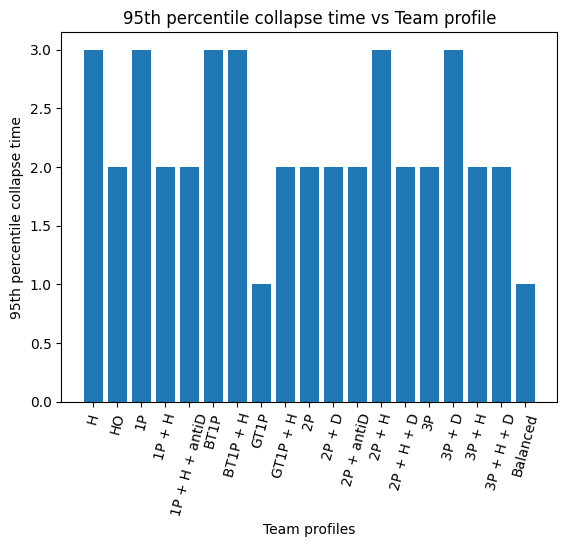

In [36]:
profiles = hidden_collapse_time.keys()

plt.bar(profiles, [np.percentile(arr, 95) for arr in hidden_collapse_time.values()])

plt.xlabel('Team profiles')
plt.ylabel('95th percentile collapse time')
plt.title('95th percentile collapse time vs Team profile')

plt.xticks(rotation=75)
plt.show()

## Average time in different zones

In [37]:
# profiles = zone0_2_hidden.keys()

# plt.bar(profiles, [np.mean(arr) for arr in zone0_2_hidden.values()])

# plt.xlabel('Team profiles')
# plt.ylabel('Avg time in [0, 2]')
# plt.title('Avg time in [0, 2] vs Team profile')

# plt.xticks(rotation=75)
# plt.show()

## How did the collapse happen?

In [38]:
timestamps = {model.name: dict() for model in models}

In [39]:
# def find_timestamps(timeseries):
#     # Find timestamps of team collapse (ingore continuous 0, only consider the time of the first 0)
#     indices = np.where(timeseries == 0)[0]
#     if not indices.any():
#         return []
    
#     timestamps = [indices[0]]
#     for i in range(1, len(indices)): # remove contiguous indices
#         if indices[i] != indices[i-1] + 1:
#             timestamps.append(indices[i])
#     return timestamps

# def find_seqs(timeseries, timestamps, window_size):
#     arr = []
#     for t in timestamps:
#         if t > window_size:
#             arr.append(timeseries[t-window_size: t].tolist())
#         else:
#             arr.append(timeseries[:t].tolist())
#     return arr
    
# def before_collapse(model, window_size = 5):
#     name = model.name
    
#     Hs = team_states[name]
#     sequences = []
    
#     for t in range(T):
#         timestamps[name][t] = find_timestamps(Hs[t])
#         seqs = find_seqs(Hs[t], timestamps[name][t], window_size)
#         sequences += seqs
        
#     return sequences

In [40]:
# for model in models:
#     if model.name == '1-Star':
#         sequences = before_collapse(model)

In [41]:
# timestamps['2-Stars']

In [42]:
# name = '1-Star'
# t = 0
# print(f'hidden            observed')
# for timestep in range(0, 20):
#     print(f'{[hidden_states[name][t][p][timestep] for p in players]}   {[observed_states[name][t][p][timestep] for p in players]}')
    

## 1-Star team collapse

In [43]:
# name = '1-Star'
# ys = [-1, 0, 1]
# t = 0
# window = 7
# start = 0
# fig, axs = plt.subplots(2, 1, figsize=(15, 7))
# colors = ['red', 'blue', 'green', 'purple', 'orange']
# markers = ['*', '^', 'x', 's', 'D']
# sizes = [14, 10, 8, 6, 4]
# for p in players:
#     i = int(p[-1]) - 1
#     label = 'star' if p == 'player1' else p
#     axs[0].plot(range(window), hidden_states[name][t][p][start: start+window] - 1, f'--', marker=markers[i], markersize=sizes[i], color=colors[i], label=label)
#     axs[1].plot(range(window), observed_states[name][t][p][start: start+window] - 1, '-', marker=markers[i], markersize=sizes[i], color=colors[i], label=label)
#     axs[0].legend()
#     axs[1].legend()
# axs[0].set_ylabel(f'Hidden state')
# axs[1].set_ylabel(f'Observed state')
# axs[0].set_xticks(range(window))
# axs[1].set_xticks(range(window))
# axs[0].set_yticks(ys)
# axs[1].set_yticks(ys)
# plt.xlabel('Time')

# # add annotations
# arrow_props = dict(facecolor='black', edgecolor='black', arrowstyle='->')
# axs[0].annotate('Team collapse', xy=(3, -1), xytext=(3, 0), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[0].annotate('Star chokes', xy=(2, -1), xytext=(2, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[0].annotate('Team recovers', xy=(4, 0), xytext=(4, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[1].annotate('Star underperforms', xy=(2, -1), xytext=(2, -0.2), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# plt.savefig(f'{plot_folder}/collapse_1_Star.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 2-Stars team collapse

In [44]:
# name = '2-Stars'
# t = 2
# window = 8
# start = 68
# fig, axs = plt.subplots(2, 1, figsize=(15, 7))
# colors = ['red', 'blue', 'green', 'purple', 'orange']
# markers = ['*', '*', 'x', 's', '^']
# sizes = [14, 10, 8, 6, 4]
# for p in players:
#     i = int(p[-1]) - 1
#     label = f'star{i+1}' if p == 'player1' or p == 'player2' else p
#     axs[0].plot(range(window), hidden_states[name][t][p][start: start+window] - 1, f'--', marker=markers[i], markersize=sizes[i], color=colors[i], label=label)
#     axs[1].plot(range(window), observed_states[name][t][p][start: start+window] - 1, '-', marker=markers[i], markersize=sizes[i], color=colors[i], label=label)
#     axs[0].legend()
#     axs[1].legend()
# axs[0].set_ylabel(f'Hidden state')
# axs[1].set_ylabel(f'Observed state')
# axs[0].set_xticks(range(window), range(start, start+window))
# axs[1].set_xticks(range(window), range(start, start+window))
# axs[0].set_yticks(ys)
# axs[1].set_yticks(ys)
# plt.xlabel('Time')

# # add annotations
# arrow_props = dict(facecolor='black', edgecolor='black', arrowstyle='->')
# axs[0].annotate('Team collapse', xy=(4, -1), xytext=(4, 0.2), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[1].annotate('Stars underperform', xy=(1, 0), xytext=(1, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[0].annotate('No team collapse', xy=(2, 0), xytext=(2, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[1].annotate('Both stars underperform', xy=(3, -1), xytext=(3, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[0].annotate('Star1 chokes', xy=(1, -1), xytext=(1, 0.5), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# axs[0].annotate('Both stars choke', xy=(3, -1), xytext=(3, 0.7), 
#                 arrowprops=arrow_props, fontsize=12, color='black')
# plt.savefig(f'{plot_folder}/collapse_2_Stars.pdf', format='pdf', bbox_inches='tight')
# plt.show()